In [1]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar


--2020-06-29 13:15:02--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.78MB/s    in 0.2s    

2020-06-29 13:15:03 (4.78 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [3]:
import matplotlib.pyplot as plt

In [4]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option('header', 'true').csv(SparkFiles.get("amazon_reviews_us_Wireless_v1_00.tsv.gz"), inferSchema=True, sep='\t')

# Show DataFrame
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...|2015-08-31 00:00:00|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...| 

In [6]:
###########################################
#                                         #
#                                         #
#          CLEANUP & TRANSFORM            #
#                                         #
#                                         #
###########################################

In [7]:
from pyspark.sql.types import IntegerType
df = df.withColumn("star_rating", df["star_rating"].cast(IntegerType()))


In [8]:
from pyspark.sql import functions as f
df = df.withColumn('review_status', f.when(f.col('star_rating') > 3, "Positive").otherwise("Negative"))


In [9]:
#drop nulls
df = df.dropna()
df.show(10, False)
                       

+-----------+-----------+--------------+----------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
#change review_date yyyy-MM-dd format
from pyspark.sql.functions  import date_format

df = df.withColumn("review_date", date_format('review_date', "yyyy-MM-dd"))
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|review_status|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|     Negative|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     51689465

In [11]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_status: string (nullable = false)



In [41]:
print((df.count(), len(df.columns)))

(9001051, 16)


In [12]:
###########################################
#                                         #
#                                         #
#        CREATE 4 DFs FOR DB LOADING      #
#                                         #
#                                         #
###########################################

In [13]:
# CREATE A TABLE OF COUNT OF CUSTOMER REVIEWS> THIS DATAFRAME WILL THEN LOAD INTO A TABLE
customercount = df.groupby("customer_id").agg({"customer_id":"count"}).withColumnRenamed("count(customer_id)","customer_count")
#customercount = customercount.dropna()
customercount = customercount.withColumn("customer_count", customercount["customer_count"].cast(IntegerType()))
#customercount.show()


In [14]:
#CREATE TABLE OF PRODUCT ID & PRODUCT TITLE > THIS DATAFRAME WILL THEN LOAD INTO A TABLE
productcount = df.dropDuplicates(['product_id']) 

productcount = productcount[['product_id','product_title']]
#productcount.show()

In [15]:
#CREATE A TABLE OF review_id, customer_id,product_id,product_parent,review_date DATE this should be int eh format yyyy-mm-dd >THIS WILL LOAD INTO TABLE

from pyspark.sql.functions import to_date
reviews = df[["review_id","customer_id","product_id","product_parent","review_date"]]
reviews = reviews.withColumn("review_date", to_date(reviews["review_date"]))
#reviews.show()

In [16]:
#CREATE A TABLE of review_id, star_rating, helpful_votes, total_votes, vine
vinereviews = df.filter(df.vine == "Y")
vinereviews = vinereviews[["review_id","star_rating","helpful_votes", "total_votes","review_body"]]
vinereviews = vinereviews.withColumnRenamed('review_body', "vine")
# vinereviews.show()

In [17]:
###########################################
#                                         #
#                                         #
#                LOADING                  #
#  !!   REMOVED  - DONE IN FILE 1 !!      #
#                                         #
###########################################

In [18]:
###########################################
#                                         #
#                                         #
#                ANALYSIS                 #
#                                         #
#                                         #
###########################################

In [19]:
positive_reviews = df.groupby('review_status').agg({'review_status':'count'})






In [20]:
#Number of positive (stars greater  than 3) and negative reviews OVERALL!
positive_reviews.show()

+-------------+--------------------+
|review_status|count(review_status)|
+-------------+--------------------+
|     Positive|             6325506|
|     Negative|             2675545|
+-------------+--------------------+



In [21]:
df[['star_rating', 'helpful_votes', 'total_votes']].describe().show()

+-------+------------------+------------------+------------------+
|summary|       star_rating|     helpful_votes|       total_votes|
+-------+------------------+------------------+------------------+
|  count|           9001051|           9001051|           9001051|
|   mean|3.8918109674081394|  0.89010127817296|1.1571524258667127|
| stddev|1.4637969296283253|11.030258895938841|11.843778940038309|
|    min|                 1|                 0|                 0|
|    max|                 5|              5854|              6063|
+-------+------------------+------------------+------------------+



In [22]:
df.columns

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date',
 'review_status']

In [23]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_status: string (nullable = false)



In [24]:
# Average Rating grouped by verified purchase
df.groupby('verified_purchase').agg({'star_rating':'mean','verified_purchase':'count','helpful_votes':"mean"}).show()

+-----------------+-----------------+------------------------+------------------+
|verified_purchase| avg(star_rating)|count(verified_purchase)|avg(helpful_votes)|
+-----------------+-----------------+------------------------+------------------+
|                Y|3.899152739684389|                 7928614| 0.702940892317371|
|                N|3.837532647605407|                 1072437| 2.273793239136658|
+-----------------+-----------------+------------------------+------------------+



In [86]:
df_vine = df[df['vine'] == "Y"]

In [88]:
df_vine.agg({'star_rating':'mean','verified_purchase':'count','helpful_votes':"mean"}).show()

+-----------------+------------------------+------------------+
| avg(star_rating)|count(verified_purchase)|avg(helpful_votes)|
+-----------------+------------------------+------------------+
|4.002574370709382|                   17480| 4.398684210526316|
+-----------------+------------------------+------------------+



In [25]:
# Looking at vine vs nonvine reviews

In [26]:
tot_vine = df[df['vine']=='Y']
tot_nonvine = df[df['vine'] =='N']
tot_vine.count()
tot_nonvine.count()
print(f"Total number of vine ratings for this category:{tot_vine.count()},  Non-Vine ratings with 4 or above: {tot_nonvine.count()}")

Total number of vine ratings for this category:17480,  Non-Vine ratings with 4 or above: 8983571


In [46]:

vine_ratings_positive = df[(df['review_status'] == "Positive") & (df['vine'] == 'Y')]
vine_ratings_negative = df[(df['review_status'] == "Negative") & (df['vine'] == 'Y')]
nonvine_ratings_positive = df[(df['review_status'] == "Positive") & (df['vine'] == 'N')]
nonvine_ratings_negative = df[(df['review_status'] == "Negative") & (df['vine'] == 'N')]




# df.filter('star_rating>4').filter('df.vine'='Y').show()

In [28]:
#rating of 3 or above
print(f"Count of Vine ratings with 3 or above:{vine_ratings.count()},  Non-Vine ratings with 3= or above: {nonvine_ratings.count()}")

Count of Vine ratings with 4 or above:6522,  Non-Vine ratings with 4 or above: 4817790


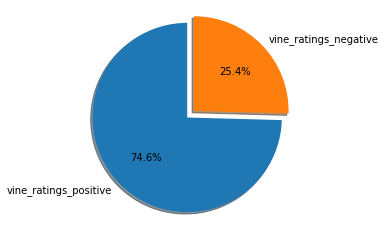

In [44]:

labels = 'vine_ratings_positive', 'vine_ratings_negative'
sizes = [vine_ratings_positive.count(), vine_ratings_negative.count()]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

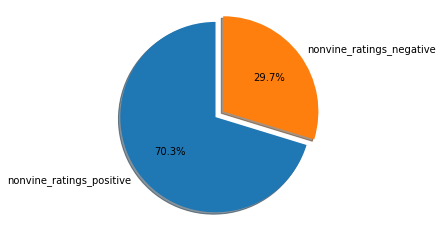

In [47]:
labels = 'nonvine_ratings_positive', 'nonvine_ratings_negative'
sizes = [nonvine_ratings_positive.count(), nonvine_ratings_negative.count()]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

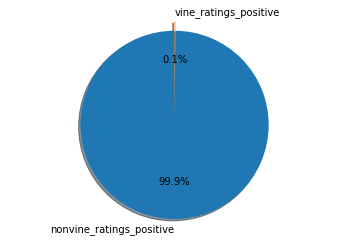

In [78]:
vine_ratings_positive = df[(df['review_status'] == "Positive") & (df['vine'] == 'Y') & (df['star_rating'] == 5)]

nonvine_ratings_positive = df[(df['review_status'] == "Positive") & (df['vine'] == 'N') & (df['star_rating'] == 5)]


labels = 'nonvine_ratings_positive', 'vine_ratings_positive'
sizes = [nonvine_ratings_positive.count(), vine_ratings_positive.count()]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [81]:
print(nonvine_ratings_positive.count(), vine_ratings_positive.count())


4817790 6522


In [82]:
###########################################
#                                         #
#                                         #
#          REVIEW TEXT ANALYSIS           #
#          ML EXTRA EXPERRIMENT           #
#                                         #
###########################################

In [66]:
# from pyspark.sql.functions import length
# # Create a length column to be used as a future feature 
# data_df = df.withColumn('length', length(df['review_body']))
# data_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|review_status|length|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|     Negative|   387|
|         US|   50800750|R15V54KBMTQ

In [67]:
# from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
# # Create all the features to the data set
# pos_neg_to_num = StringIndexer(inputCol='review_status',outputCol='label')
# tokenizer = Tokenizer(inputCol="review_body", outputCol="token_text")
# stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
# hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
# idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [68]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.linalg import Vector

# # Create feature vectors
# clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

In [69]:
# # Create a and run a data processing Pipeline
# from pyspark.ml import Pipeline
# data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [71]:
# # Fit and transform the pipeline
# cleaner = data_prep_pipeline.fit(data_df)
# cleaned = cleaner.transform(data_df)

In [72]:
# cleaned.select(['label','features']).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(262145,[7062,733...|
|  0.0|(262145,[5765,744...|
|  0.0|(262145,[3121,186...|
|  0.0|(262145,[12888,24...|
|  0.0|(262145,[87603,10...|
|  0.0|(262145,[113462,1...|
|  0.0|(262145,[87603,96...|
|  0.0|(262145,[12888,13...|
|  0.0|(262145,[27293,43...|
|  1.0|(262145,[13101,33...|
|  0.0|(262145,[38870,40...|
|  0.0|(262145,[47502,11...|
|  0.0|(262145,[9521,184...|
|  1.0|(262145,[10098,12...|
|  0.0|(262145,[119418,1...|
|  1.0|(262145,[6369,139...|
|  0.0|(262145,[132458,2...|
|  0.0|(262145,[118642,2...|
|  0.0|(262145,[33933,88...|
|  0.0|(262145,[102787,1...|
+-----+--------------------+
only showing top 20 rows



In [89]:
# from pyspark.ml.classification import NaiveBayes
# # Break data down into a training set and a testing set
# training, testing = cleaned.randomSplit([0.7, 0.3])

# # Create a Naive Bayes model and fit training data
# nb = NaiveBayes()
# predictor = nb.fit(training)

KeyboardInterrupt: ignored

In [52]:
# newFrame.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+--------------------+--------------------+-------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|review_status|               words|            filtered|review_length|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+--------------------+--------------------+-------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|

In [57]:

# hashingTF = HashingTF(inputCol="words",outputCol='hash_token')

In [49]:
# idf = IDF(inputCol='hash_token',outputCol="idf_token")

In [53]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.linalg import Vector

# clean_up = VectorAssembler(inputCols=['idf_token', "review_length"], outputCol='features')